In [1]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = './Data_Ankle.mat'
data_mat = loadmat(data_path)

In [3]:
data_matrix = data_mat['ankle_data']
data_matrix.shape

(48000, 6)

In [4]:
columns = ['Time', 'Vertical Ground_Reaction_Force', 'Hip_Angle', 'Knee_Angle', 'Ankle_Angle', 'Ankle_Moment']
data_df = pd.DataFrame(data_matrix, columns=columns)
missing_values = data_df.isnull().sum()
data_df.head(), missing_values

(   Time  Vertical Ground_Reaction_Force  Hip_Angle  Knee_Angle  Ankle_Angle  \
 0  0.00                       10.748116   0.292974    0.825063    -1.492588   
 1  0.01                        8.231421   0.293179    0.822469    -1.493192   
 2  0.02                        6.204634   0.294008    0.810997    -1.495867   
 3  0.03                        5.083716   0.295568    0.785731    -1.501793   
 4  0.04                        4.816681   0.297472    0.745707    -1.511208   
 
    Ankle_Moment  
 0     -1.926491  
 1     -1.984065  
 2     -1.921029  
 3     -1.727272  
 4     -1.440258  ,
 Time                              0
 Vertical Ground_Reaction_Force    0
 Hip_Angle                         0
 Knee_Angle                        0
 Ankle_Angle                       0
 Ankle_Moment                      0
 dtype: int64)

In [5]:
data_to_scale = data_df.drop(columns=['Time'])

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

In [7]:
scaled_df = pd.DataFrame(scaled_data, columns=columns[1:])
scaled_df['Time'] = data_df['Time']

In [8]:
train_size = int(0.8 * len(scaled_df))
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

In [9]:
X_train_1 = train_data[['Ankle_Angle', 'Vertical Ground_Reaction_Force', 'Hip_Angle', 'Knee_Angle']].values
y_train_1 = train_data['Ankle_Moment'].values

X_test_1 = test_data[['Ankle_Angle', 'Vertical Ground_Reaction_Force', 'Hip_Angle', 'Knee_Angle']].values
y_test_1 = test_data['Ankle_Moment'].values

In [10]:
X_train_1_cnn = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], 1)
X_test_1_cnn = X_test_1.reshape(X_test_1.shape[0], X_test_1.shape[1], 1)

X_train_1_cnn.shape, X_test_1_cnn.shape, y_train_1.shape, y_test_1.shape

((38400, 4, 1), (9600, 4, 1), (38400,), (9600,))

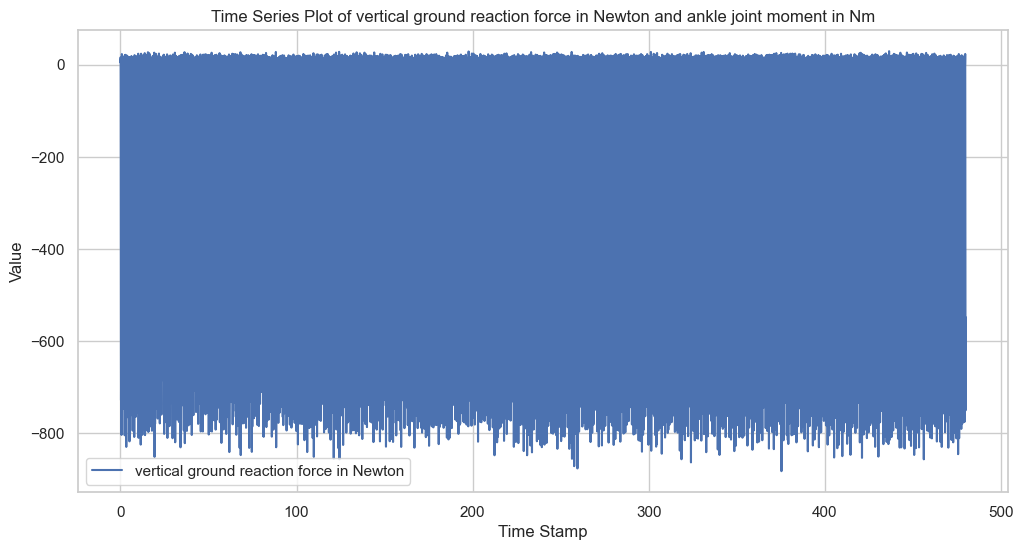

In [19]:
import matplotlib.pyplot as plt


# Select the specific feature and target
feature_column = 'vertical ground reaction force in Newton'
target_column = 'ankle joint moment in Nm'

# Create a time series line plot
plt.figure(figsize=(12, 6))
plt.plot(data_df['time'], data_df[feature_column], label=feature_column)
#plt.plot(data_df['time'], data_df[target_column], label=target_column)
plt.title(f'Time Series Plot of {feature_column} and {target_column}')
plt.xlabel('Time Stamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
#time", "vertical ground reaction force in Newton", "hip joint angle", "knee joint angle", 
#"ankle joint angle", "ankle joint moment in Nm"]

In [11]:
def extract_data_for_combination(columns):
    X_train = train_data[columns].values
    y_train = train_data['Ankle_Moment'].values
    X_test = test_data[columns].values
    y_test = test_data['Ankle_Moment'].values
    # Reshape for RNN
    X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    return X_train_rnn, y_train, X_test_rnn, y_test

In [12]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import LSTM

def create_rnn_model_for_combination(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
X_train_4_rnn, y_train_4, X_test_4_rnn, y_test_4 = extract_data_for_combination(['Ankle_Angle', 'Knee_Angle', 'Hip_Angle', 'Vertical Ground_Reaction_Force'])
rnn_model_4 = create_rnn_model_for_combination(input_shape=(X_train_4_rnn.shape[1], X_train_4_rnn.shape[2]))
rnn_model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_4 = rnn_model_4.fit(X_train_4_rnn, y_train_4, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50
480/480 [==============================] - 2s 2ms/step - loss: 0.1419 - val_loss: 0.0298
Epoch 2/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0364 - val_loss: 0.0258
Epoch 3/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0232
Epoch 4/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0217
Epoch 5/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0205
Epoch 6/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0198
Epoch 7/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0200
Epoch 8/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0296 - val_loss: 0.0187
Epoch 9/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0184
Epoch 10/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0199

In [71]:
loss_4 = rnn_model_4.evaluate(X_test_4_rnn, y_test_4)
print("Test loss for combination 1:", loss_4)


300/300 [==============================] - 1s 1ms/step - loss: 0.0121
Test loss for combination 1: 0.01205618679523468


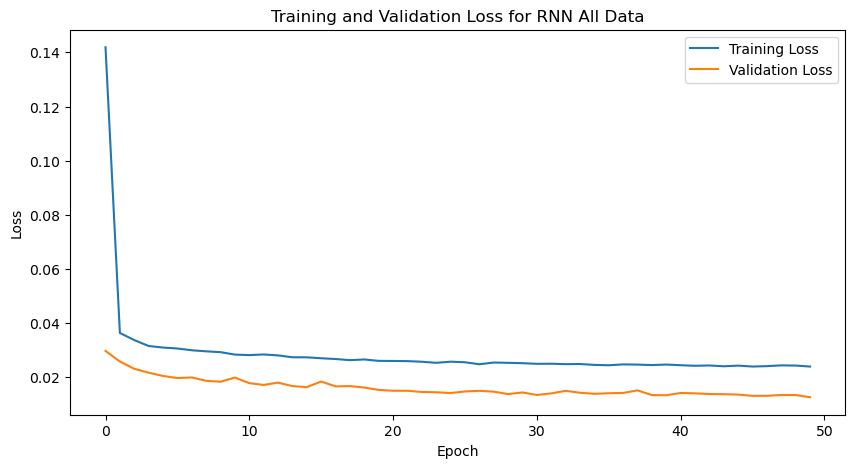

In [15]:
train_loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

# Plotting training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for RNN All Data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [58]:
X_train_4_rnn.shape

(38400, 1, 4)

In [18]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
model = Sequential()
model.add(Conv1D(16, kernel_size=(1,), activation="relu", input_shape=(4,1)))
#model.add(Conv2D(32, kernel_size=(2,), activation="relu"))
model.add(Flatten())
model.compile(loss="mse", optimizer="adam")
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

In [20]:
fit = model.fit(X_train_1_cnn, y_train_1, batch_size=12, validation_split=0.2, epochs=50)

Epoch 1/50
2560/2560 [==============================] - 306s 120ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 2/50
2560/2560 [==============================] - 295s 115ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 3/50
2560/2560 [==============================] - 297s 116ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 4/50
2560/2560 [==============================] - 304s 119ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 5/50
2560/2560 [==============================] - 303s 118ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 6/50
2560/2560 [==============================] - 325s 127ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 7/50
2560/2560 [==============================] - 300s 117ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 8/50
2560/2560 [==============================] - 301s 118ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 9/50
2560/2560 [==============================] - 302s 118ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 10/50
2560/2560 [=======================

In [65]:
loss = model.evaluate(X_test_1_cnn, y_test_1)
print("Test loss for combination 1:", loss)

300/300 [==============================] - 0s 869us/step - loss: 0.0118
Test loss for combination 1: 0.01184778194874525


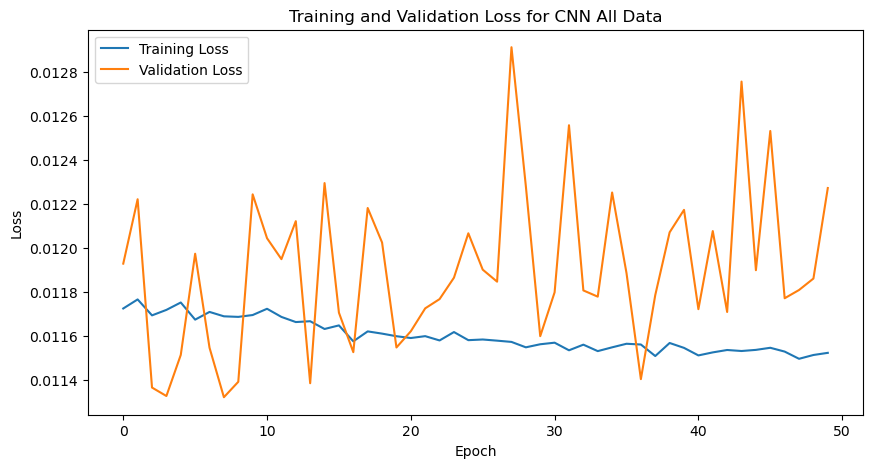

In [22]:
train_loss = fit.history['loss']
val_loss = fit.history['val_loss']

# Plotting training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for CNN All Data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()